In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import os
os.chdir('gdrive/My Drive/Colab Notebooks/image_classifier/')

In [4]:
%%capture
!pip install livelossplot
!pip install efficientnet

In [5]:
!ls

complete_model.h5		       model.h5
data				       model.json
data2				       model_summary.gdoc
data.zip			       model_summary.txt
ImageClassifierCNN-EfficientNet.ipynb  README.md
ImageClassifierCNN.ipynb	       training_logs.csv
LICENSE


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.optimizers import RMSprop
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D
from keras.callbacks import CSVLogger
from livelossplot.keras import PlotLossesCallback
import efficientnet.keras as efn

Using TensorFlow backend.


In [7]:
# !unzip data.zip

In [8]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "model.h5"

# Data
path = "data/"
training_data_dir = path + "training"
validation_data_dir = path + "validation"
test_data_dir = path + "test"

In [9]:
# Hyperparams
IMAGE_SIZE = 200
IMAGE_WIDTH, IMAGE_HEIGHT = 128, 32
EPOCHS = 50
BATCH_SIZE = 32
TEST_SIZE = 30

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [15]:
model = Sequential()

model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=0.0001),
            metrics=['accuracy'])

with open(MODEL_SUMMARY_FILE,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(128, 32, ..., activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 32, 32)       896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 32, 32)       9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 16, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 8, 64)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 8, 128)       

In [17]:
# Data augmentation
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [18]:
# Data preparation
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")
validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode="binary", 
    shuffle=False)

Found 901 images belonging to 2 classes.
Found 154 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [23]:
# Training
model.fit_generator(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    
    verbose=1)
model.save_weights(MODEL_FILE)

Epoch 1/30
28/28 [==============================] - 3s 114ms/step - loss: 0.3812 - accuracy: 0.8182 - val_loss: 0.2485 - val_accuracy: 0.8125
Epoch 2/30
28/28 [==============================] - 3s 114ms/step - loss: 0.3901 - accuracy: 0.8285 - val_loss: 0.4647 - val_accuracy: 0.7623
Epoch 3/30
28/28 [==============================] - 3s 111ms/step - loss: 0.3552 - accuracy: 0.8458 - val_loss: 0.2226 - val_accuracy: 0.8525
Epoch 4/30
28/28 [==============================] - 3s 112ms/step - loss: 0.3518 - accuracy: 0.8446 - val_loss: 0.2916 - val_accuracy: 0.8443
Epoch 5/30
28/28 [==============================] - 3s 112ms/step - loss: 0.3452 - accuracy: 0.8470 - val_loss: 0.5576 - val_accuracy: 0.8525
Epoch 6/30
28/28 [==============================] - 3s 114ms/step - loss: 0.3493 - accuracy: 0.8596 - val_loss: 0.5534 - val_accuracy: 0.8281
Epoch 7/30
28/28 [==============================] - 3s 121ms/step - loss: 0.2935 - accuracy: 0.8862 - val_loss: 0.2736 - val_accuracy: 0.8279
Epoch 

In [24]:
model.save("complete_model.h5")

In [25]:
new_model = load_model("complete_model.h5")

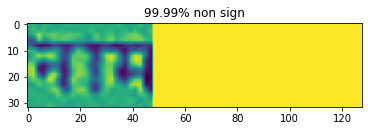

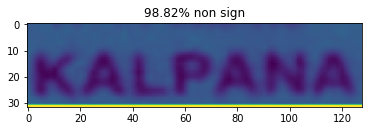

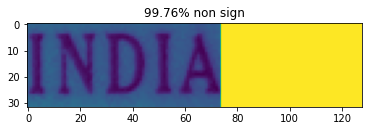

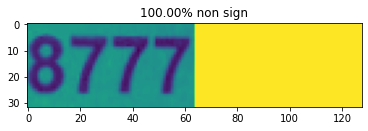

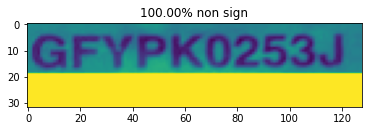

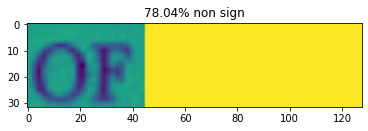

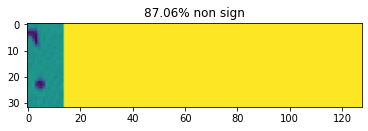

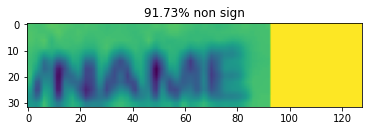

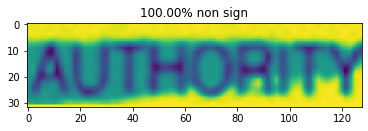

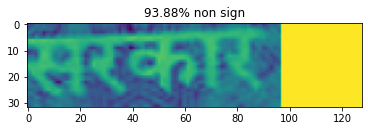

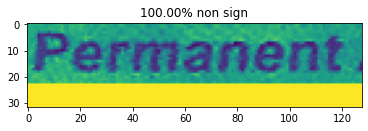

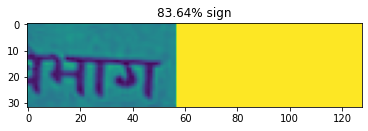

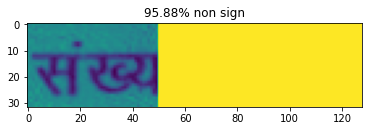

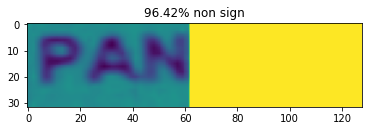

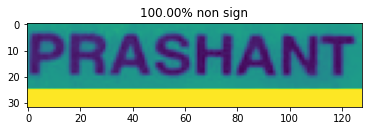

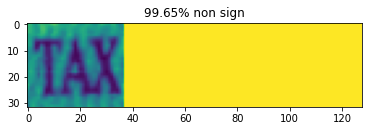

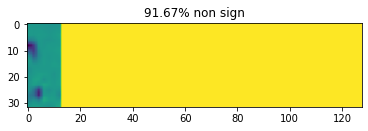

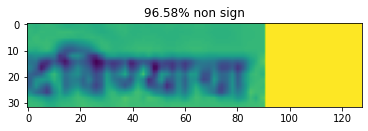

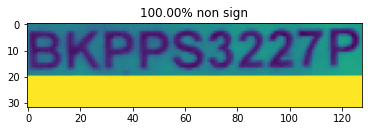

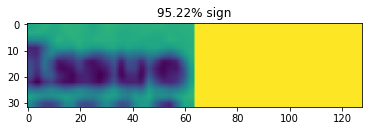

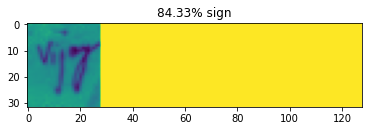

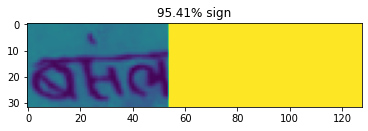

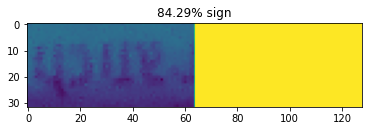

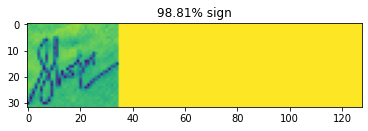

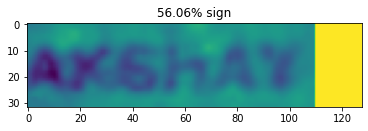

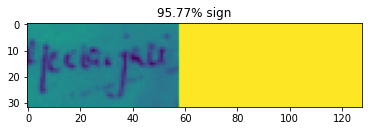

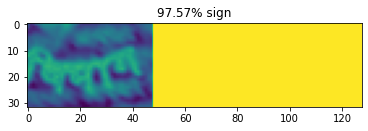

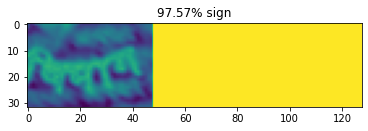

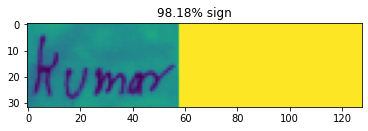

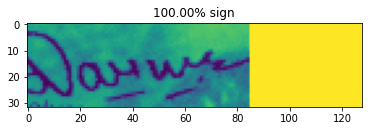

In [26]:
# Testing 
probabilities = new_model.predict_generator(test_generator, TEST_SIZE)
for index, probability in enumerate(probabilities):
    image_path = test_data_dir + "/" +test_generator.filenames[index]
    img = mpimg.imread(image_path)
    plt.imshow(img)
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% sign")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% non sign") 
    plt.show()